In [30]:
import numpy as np
import numba
from numba.types import *
from numba import prange
import matplotlib.pyplot as plt
from numpy.linalg import eig, multi_dot, inv
from numpy import sin
from numpy import pi
from scipy.optimize import curve_fit
from scipy.linalg import schur
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size']=20
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy.stats import linregress

In [31]:
S=200
dim=int(2*S+1)
τ=1
k=6
p=np.pi/2
i=complex(0, 1)
basis = np.identity(dim)
N_av=100


In [32]:
#Definition of the ladder operators
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_p(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 2*S:
        coef=0
        return (coef, ket_out)
    else:
        coef=np.sqrt(S*(S+1)-m*(m+1))
        ket_out[site+1]= 1
        return (coef, ket_out)
@numba.jit(numba.types.Tuple((float64, float64[:]))(float64[:], float64), nopython=True, fastmath=True, parallel=False)
def S_m(ket, S):
    site= np.argmax(ket)
    m=site-S
    ket_out=np.zeros(dim)
    if site== 0:
        coef=0
        return (coef, ket_out)
    else:
        coef= np.sqrt(S*(S+1)-m*(m-1))
        ket_out[site-1]= 1
        return (coef, ket_out)

In [33]:
@numba.jit(float64(float64[:], float64[:]), nopython=True, fastmath=True, parallel=False)
def braket(bra, ket):
    if np.all(bra== ket):
        return 1
    else:
        return 0

In [34]:
LOOKUP_TABLE = np.array([
    1, 1, 2, 6, 24, 120, 720, 5040, 40320,
    362880, 3628800, 39916800, 479001600,
    6227020800, 87178291200, 1307674368000,
    20922789888000, 355687428096000, 6402373705728000,
    121645100408832000, 2432902008176640000], dtype='int64')

@numba.jit(float64(int64), nopython=True, fastmath=True, parallel=False)
def fast_log_factorial(n):
    if n<20:
        return np.log(LOOKUP_TABLE[n])
    else:
        #stirling approx
        return n*np.log(n)-n+ 0.5*np.log(2*np.pi*n)
        #return n*np.log(n)-n+ 0.5*np.log(2*np.pi*n)+ 1/(12*n)-1/(360*n**3)

In [35]:
@numba.jit(float64[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sx(basis, S):
    dim=int(2*S+1)
    Sx=np.zeros((dim, dim))
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sx[j, k]=(coef_p*result_p+ coef_m*result_m)/2
    return Sx

@numba.jit(complex128[:,:](float64[:, :], float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sy(basis, S):
    dim=int(2*S+1)
    Sy=np.zeros((dim, dim), dtype=complex128)
    i=complex(0,1)
    for j in range(dim):
        for k in range(dim):
            ket=basis[j, :]
            bra=basis[k, :]
            coef_p, S_p_ket=S_p(ket, S)
            coef_m, S_m_ket=S_m(ket, S)
            result_p=braket(bra, S_p_ket)
            result_m=braket(bra, S_m_ket)
            Sy[j, k]=-i*(coef_p*result_p- coef_m*result_m)/2
    return Sy

@numba.jit(float64[:,:](float64), nopython=True, fastmath=True, parallel=False)
def Compute_Sz(S):
    dim=int(2*S+1)
    Sz=np.zeros((dim, dim))
    for j in range(dim):
        m=j-S
        Sz[dim-1-j, dim-1-j]=m
    return Sz

In [36]:
#Take into account that z is complex
@numba.jit(complex128[:](float64, complex128), nopython=True, fastmath=True, parallel=False)
def define_zeta(S, z):
    dim=int(2*S+1)
    ket_z=np.zeros(dim, dtype=complex128)
    for k in range(dim):
        m=k-S
        aux1=fast_log_factorial(int(2*S)) #aux1= log((2S)!)
        aux2=fast_log_factorial(int(S+m)) #aux2= log((S+m)!)
        aux3=fast_log_factorial(int(S-m)) #aux3= log((S-m)!)
        #ket_z[j]=np.sqrt(aux1/(aux2*aux3))*z**(S+m)/(1 + (np.abs(z))**2)**S
        #To deal with big numbers we introduce the log 
        #of the factorial, compute the division of them and afterwards we exponentiate
        ket_z[k]=np.exp((aux1-aux2-aux3)/2)*z**(S+m)/((1 + (np.abs(z))**2)**S) 
    norm= np.sqrt(np.conjugate(ket_z)@ket_z)
    return ket_z/norm
def linear(x, m,n):
    return m*x+n

In [37]:
@numba.njit(float64(complex128[:,:], complex128[:]))
def computeFidelity(U_n, psi0):
    return (np.abs(np.conjugate(psi0)@U_n@psi0))**2
#@numba.njit(float64(float64, float64, complex128[:,:], complex128[:,:], complex128[:,:], complex128[:]))
def avE_Semianalytic(p, k_tilde, Sx, Sz, chi, coefchi):
    eps_n=np.zeros(dim)
    aux=p*Sx+k_tilde*Sz@Sz
    for n in range(dim):
        eps_n[n]=np.conjugate(chi[:,n])@aux@chi[:,n]
    avE=np.sum((np.abs(coefchi))**2*eps_n)
    return avE
#@numba.njit(float64(float64, float64, complex128[:,:], complex128[:,:], complex128[:,:], complex128[:]))
def stdE_Semianalytic(p, k_tilde, Sx, Sz, chi, coefchi):
    eps2_n=np.zeros(dim)
    aux2=p**2*Sx@Sx/2+k_tilde**2*Sz@Sz@Sz@Sz+p*k_tilde*Sx@Sz@Sz
    for n in range(dim):
        eps2_n[n]=np.conjugate(chi[:,n])@aux2@chi[:,n]
    avE2=np.sum((np.abs(coefchi))**2*eps2_n)
    avE=avE_Semianalytic(p, k_tilde, Sx, Sz, chi, coefchi)
    return np.sqrt(avE2-avE**2)
#@numba.njit()
def compute_tQSL(E, F_t, coefchi, p, k_tilde, Sx, Sz, chi):
    L=np.arccos(np.sqrt(F_t))
    avE=np.sum((np.abs(coefchi))**2*E)
    stdE=np.sum((np.abs(coefchi))**2*E**2)
    stdE=np.sqrt(stdE-avE**2)
    avE_analyt=avE_Semianalytic(p, k_tilde, Sx, Sz, chi, coefchi)-np.min(E)
    stdE_analyt=stdE_Semianalytic(p, k_tilde, Sx, Sz, chi, coefchi)
    avE=avE-np.min(E)
    minMTML=np.min(np.asarray([avE, stdE]))
    minMTML_analyt=np.min(np.asarray([avE_analyt, stdE_analyt]))
    return np.real(L/minMTML), np.real(L/minMTML_analyt)


<ipython-input-37-319c65f15535>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 1d, C), array(complex128, 1d, A))
  return (np.abs(np.conjugate(psi0)@U_n@psi0))**2
<ipython-input-37-319c65f15535>:3: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 1d, C), array(complex128, 2d, A))
  return (np.abs(np.conjugate(psi0)@U_n@psi0))**2
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 1d, C), array(complex128, 2d, A))
  warnings.warn(NumbaPerformanceWarning(msg))
/home/pablo/anaconda3/lib/python3.7/site-packages/numba/typing/npydecl.py:958: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(complex128, 1d, C), array(complex128, 1d, A))
  warnings.warn(NumbaPerformanceWarning(msg))


In [38]:
Sx=np.zeros((dim, dim))
Sy=np.zeros((dim, dim), dtype=complex)
Sx=Compute_Sx(basis, S)
Sy=Compute_Sy(basis, S) #I've checked that for S=1/2, 1, 3/2 the results are the expected ones
Sz=Compute_Sz(S)

In [39]:
#FLoquet op. definition
U=expm(- i*k*Sz@Sz/(2*S))@expm(-i*p*Sy)
eigval, chi=eig(U)
eps=np.log(eigval)/i

In [40]:
t_max=30
t_arr=np.arange(0,t_max, 1)
n_t=len(t_arr)
F_arr=np.zeros(n_t)
θ_coh=0.8
ϕ_coh=np.pi/2
z=np.exp(i*ϕ_coh)*np.tan(θ_coh/2)
psi0=define_zeta(S,z)
psi0_chi=chi@psi0
U_n=np.identity(dim, dtype=complex)
for m in range(n_t):
    F_arr[m]=computeFidelity(U_n, psi0)
    U_n=U_n@U
tQSL, tQSL_analyt=compute_tQSL(eps, F_arr, psi0_chi, p, k/(2*S), Sx, Sz, chi)
L=np.arccos(np.sqrt(F_arr))
dL=np.zeros(n_t)
dF=np.zeros(n_t)
for k in range(1, n_t):
    dL[k]=L[k]-L[k-1]
    dF[k]=F_arr[k]-F_arr[k-1]

/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':
/home/pablo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [41]:
#print(F_arr)

In [42]:
"""plt.figure()
plt.scatter(t_arr, np.abs(2*np.sqrt(F_arr)*dL))
plt.plot(t_arr, 1/tQSL*np.sqrt(1-F_arr))
plt.yscale('log')
plt.ylim(1e-4, 2)
plt.show()"""

"plt.figure()\nplt.scatter(t_arr, np.abs(2*np.sqrt(F_arr)*dL))\nplt.plot(t_arr, 1/tQSL*np.sqrt(1-F_arr))\nplt.yscale('log')\nplt.ylim(1e-4, 2)\nplt.show()"

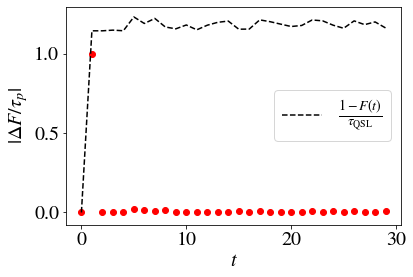

In [45]:
plt.figure()
plt.scatter(t_arr, np.abs(dF), color='red')
plt.plot(t_arr, (1-F_arr)/tQSL, color='black', ls='--', label=r"$\frac{1-F(t)}{\tau_\mathrm{QSL}}$")
#plt.plot(t_arr, (1-F_arr)/tQSL_analyt, color='blue', ls='-.', label=r"$\frac{1-F(t)}{\tau_\mathrm{QSL}}$")
#plt.yscale('log')
plt.legend()
plt.ylabel(r"$\left|\Delta F/\tau_p\right|$")
plt.xlabel("$t$")
plt.show()

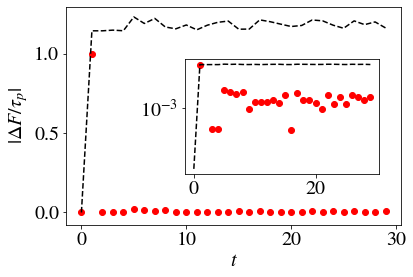

In [61]:
fig, ax1 = plt.subplots()

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.4, 0.3, 0.45, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

#plt.figure()
ax1.scatter(t_arr, np.abs(dF), color='red')
ax1.plot(t_arr, (1-F_arr)/tQSL, color='black', ls='--', label=r"$\frac{1-F(t)}{\tau_\mathrm{QSL}}$")
ax2.scatter(t_arr, np.abs(dF), color='red')
ax2.plot(t_arr, (1-F_arr)/tQSL, color='black', ls='--')
ax2.set_yscale('log')
#plt.plot(t_arr, (1-F_arr)/tQSL_analyt, color='blue', ls='-.', label=r"$\frac{1-F(t)}{\tau_\mathrm{QSL}}$")
#plt.yscale('log')
#ax1.legend()
ax1.set_ylabel(r"$\left|\Delta F/\tau_p\right|$")
ax1.set_xlabel("$t$")
plt.show()